## Implementing the Skip-Gram Model
### Main Contributor:
Raphael Steinborn

### Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
import random
import nltk
from scipy.spatial.distance import cosine
nltk.download('punkt')

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/opt/homebrew/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raphaelsteinborn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Preprocessing

In [2]:
# Define a text corpus
custom_corpus = """
The quick brown fox jumps over the lazy dog.
In the heart of the city, the tall skyscrapers glistened under the sun.
Alice loves reading books about adventures and mysteries.
The capital of France is Paris, known for the Eiffel Tower.
New York is famous for its Statue of Liberty and Times Square.
The scientist conducted an experiment in the laboratory.
He bought a new car and drove to the countryside.
The chef prepared a delicious meal for the guests.
In the jungle, the lion is considered the king of the beasts.
She enjoys painting landscapes and portraits in her free time.
The economy of Japan is one of the strongest in the world.
The Nile River is the longest river in Africa.
Mount Everest is the highest mountain on Earth.
The Great Wall of China is an ancient series of walls and fortifications.
The teacher explained the theory of relativity to the students.
Technology has significantly advanced over the past few decades.
Farmers grow crops and raise livestock on their farms.
The software engineer developed a new application for smartphones.
The pilot flew the airplane across the Atlantic Ocean.
The doctor diagnosed the patient with a rare disease.
A meteorologist predicts the weather using various instruments.
The history of Rome includes legendary tales of gladiators and emperors.
The treasure hunters discovered an old map leading to hidden riches.
The musician composed a symphony that moved the audience to tears.
In ancient Greece, philosophers like Socrates and Plato pondered life's mysteries.
"""

# Tokenize the text corpus
def tokenize(text):
    return nltk.word_tokenize(text.lower())

words = tokenize(custom_corpus)

In [3]:
# Build vocabulary
def build_vocab(words):
    vocab = Counter(words)
    vocab_size = len(vocab)
    word_to_idx = {word: i for i, word in enumerate(vocab)}
    idx_to_word = {i: word for word, i in word_to_idx.items()}
    return vocab, vocab_size, word_to_idx, idx_to_word

vocab, vocab_size, word_to_idx, idx_to_word = build_vocab(words)

### Generate Training Data

In [4]:
def generate_training_data(words, word_to_idx, window_size):
    data = []
    for i in range(len(words)):
        target = word_to_idx[words[i]]
        context = []
        for j in range(-window_size, window_size + 1):
            if j != 0 and 0 <= i + j < len(words):
                context.append(word_to_idx[words[i + j]])
        for context_word in context:
            data.append((target, context_word))
    return data

window_size = 10 # Here we define the context window size
training_data = generate_training_data(words, word_to_idx, window_size)

### Define the Skip-gram Model

In [5]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim) # Input word embeddings
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim) # Output word embeddings
    
    def forward(self, center_word, context_word, negative_samples):
        # Get embeddings for center word, context word, and negative samples
        center_embed = self.in_embeddings(center_word)
        context_embed = self.out_embeddings(context_word)
        neg_embed = self.out_embeddings(negative_samples)
        
        # Calculate positive & negative score
        pos_score = torch.matmul(context_embed, center_embed.transpose(0, 1))
        neg_score = torch.matmul(neg_embed, center_embed.transpose(0, 1))
        
        # Calculate positive & negative loss
        pos_loss = torch.log(torch.sigmoid(pos_score)).squeeze()
        neg_loss = torch.log(torch.sigmoid(-neg_score)).sum()
        
        return -(pos_loss + neg_loss) # Return total loss

### Implement Negative Sampling

In [6]:
def get_negative_samples(target, vocab_size, k=5):
    neg_samples = []
    while len(neg_samples) < k:
        sample = random.randint(0, vocab_size - 1)
        if sample != target:
            neg_samples.append(sample)
    return torch.tensor(neg_samples) # Convert the list of negative samples to a tensor

### Train the Model

Epoch: 0, Loss: 35563.561407864094
Epoch: 1, Loss: 27128.322294652462
Epoch: 2, Loss: 21179.724696278572
Epoch: 3, Loss: 17561.045812934637
Epoch: 4, Loss: 15254.484360739589
Epoch: 5, Loss: 13924.841402113438
Epoch: 6, Loss: 13253.584726907313
Epoch: 7, Loss: 12777.260829538107
Epoch: 8, Loss: 12554.451159641147
Epoch: 9, Loss: 12392.533685922623
Epoch: 10, Loss: 12230.993297696114
Epoch: 11, Loss: 12069.885131180286
Epoch: 12, Loss: 11977.801159918308
Epoch: 13, Loss: 11814.600088775158
Epoch: 14, Loss: 11733.843227922916
Epoch: 15, Loss: 11654.926172986627
Epoch: 16, Loss: 11536.311896428466
Epoch: 17, Loss: 11331.229705542326
Epoch: 18, Loss: 11193.734188258648
Epoch: 19, Loss: 11099.61358398199
Epoch: 20, Loss: 10989.29401884973
Epoch: 21, Loss: 10790.385626077652
Epoch: 22, Loss: 10713.766807436943
Epoch: 23, Loss: 10557.762197598815
Epoch: 24, Loss: 10454.472139015794
Epoch: 25, Loss: 10361.406960651278
Epoch: 26, Loss: 10150.008763447404
Epoch: 27, Loss: 10166.256768658757
Epoc

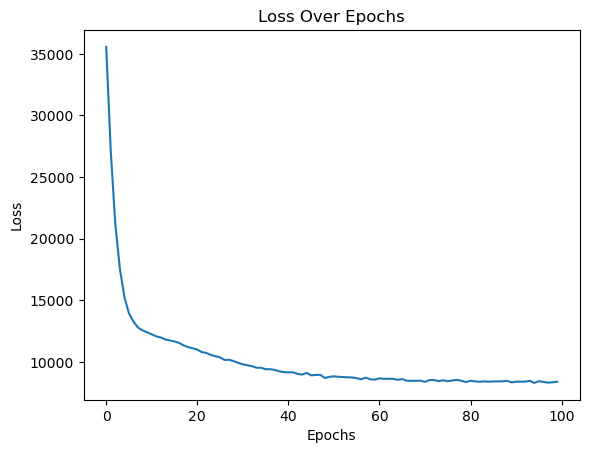

In [7]:
def train_model(model, training_data, vocab_size, embedding_dim, learning_rate=0.01, epochs=100):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        random.shuffle(training_data)
        
        for target, context in training_data:
            target_tensor = torch.tensor([target], dtype=torch.long)
            context_tensor = torch.tensor([context], dtype=torch.long)
            neg_samples_tensor = get_negative_samples(target, vocab_size, k=5)
            
            model.zero_grad()
            loss = model(target_tensor, context_tensor, neg_samples_tensor)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss_history.append(total_loss)
        print(f'Epoch: {epoch}, Loss: {total_loss}')
    
    return loss_history

# Train the model and get the loss history
embedding_dim = 10 # Here we define embedding dimension
model = SkipGramModel(vocab_size, embedding_dim)
loss_history = train_model(model, training_data, vocab_size, embedding_dim, learning_rate=0.01, epochs=100)

# Plot the loss history
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.show()

### Evaluate the Model

In [8]:
# Evaluate the Model
def get_word_embedding(word, word_to_idx, model):
    if word not in word_to_idx:
        print(f"Word '{word}' not found in vocabulary.")
        return None
    word_idx = word_to_idx[word]
    word_tensor = torch.tensor([word_idx], dtype=torch.long)
    return model.in_embeddings(word_tensor).detach().numpy().flatten()

def evaluate_model(model, word_to_idx, words_to_evaluate):
    def word_similarity(word1, word2):
        emb1 = get_word_embedding(word1, word_to_idx, model)
        emb2 = get_word_embedding(word2, word_to_idx, model)
        if emb1 is None or emb2 is None:
            return None
        return 1 - cosine(emb1, emb2)
    
    for word1, word2 in words_to_evaluate:
        similarity = word_similarity(word1, word2)
        if similarity is not None:
            print(f'Similarity between "{word1}" and "{word2}": {similarity}')

# Words to evaluate
words_to_evaluate = [('paris', 'france'), ('japan', 'economy')]

# Evaluate the model
evaluate_model(model, word_to_idx, words_to_evaluate)

Similarity between "paris" and "france": 0.9624528884887695
Similarity between "japan" and "economy": 0.9589616060256958


### Solve Analogies Using Vector Arithmetic

In [9]:
def solve_analogy(word_a, word_b, word_c, word_to_idx, model):
    vec_a = get_word_embedding(word_a, word_to_idx, model)
    vec_b = get_word_embedding(word_b, word_to_idx, model)
    vec_c = get_word_embedding(word_c, word_to_idx, model)
    
    target_vec = vec_b - vec_a + vec_c

    min_distance = float('inf')
    closest_word = None
    for word, idx in word_to_idx.items():
        if word in {word_a, word_b, word_c}:  # Skip input words to avoid trivial solutions
            continue
        word_vec = get_word_embedding(word, word_to_idx, model)
        distance = np.linalg.norm(word_vec - target_vec)
        if distance < min_distance:
            min_distance = distance
            closest_word = word
    return closest_word

# Example analogies to evaluate
analogies = [
    ('paris', 'france', 'china'),  # paris : france :: china : ?
    ('jungle', 'lion', 'king'),  # jungle : lion :: king : ?
    ('history', 'tales', 'treasure'),  # history : tales :: treasure : ?
    ('brown', 'fox', 'lazy'),  # brown : fox :: lazy : ?
]

for word_a, word_b, word_c in analogies:
    result = solve_analogy(word_a, word_b, word_c, word_to_idx, model)
    if result:
        print(f"{word_a} : {word_b} :: {word_c} : {result}")

paris : france :: china : wall
jungle : lion :: king : beasts
history : tales :: treasure : hunters
brown : fox :: lazy : jumps


### Evaluate Compositionality of Learned Vectors

In [10]:
def evaluate_compositionality(word1, word2, word_to_idx, model):
    vec1 = get_word_embedding(word1, word_to_idx, model)
    vec2 = get_word_embedding(word2, word_to_idx, model)
    combined_vec = vec1 + vec2

    min_distance = float('inf')
    closest_word = None
    for word, idx in word_to_idx.items():
        word_vec = get_word_embedding(word, word_to_idx, model)
        distance = np.linalg.norm(word_vec - combined_vec)
        if distance < min_distance:
            min_distance = distance
            closest_word = word
    return closest_word

# Example evaluation of compositionality
word_pairs = [
    ("france", "capital"),  # france + capital ≈ ?
    ("treasure", "map"),  # treasure + map ≈ ?
    ("greece", "socrates"),  # greece + socrates ≈ ?
    ("france", "tower"),  # france + tower ≈ ?
    ("smartphones", "software"),  # smartphones + software ≈ ?
]

for word1, word2 in word_pairs:
    result = evaluate_compositionality(word1, word2, word_to_idx, model)
    print(f"{word1} + {word2} ≈ {result}")

france + capital ≈ paris
treasure + map ≈ old
greece + socrates ≈ like
france + tower ≈ paris
smartphones + software ≈ application


### Plotting

In [11]:
# Get word embeddings
def get_word_embeddings(words, word_to_idx, model):
    embeddings = []
    for word in words:
        word_idx = word_to_idx[word]
        word_tensor = torch.tensor([word_idx], dtype=torch.long)
        embedding = model.in_embeddings(word_tensor).detach().numpy().flatten()
        embeddings.append(embedding)
    return np.array(embeddings)

# Reduce dimensions using t-SNE or PCA
def reduce_dimensions(embeddings, method='tsne'):
    if method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        reduced_embeddings = tsne.fit_transform(embeddings)
    elif method == 'pca':
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings


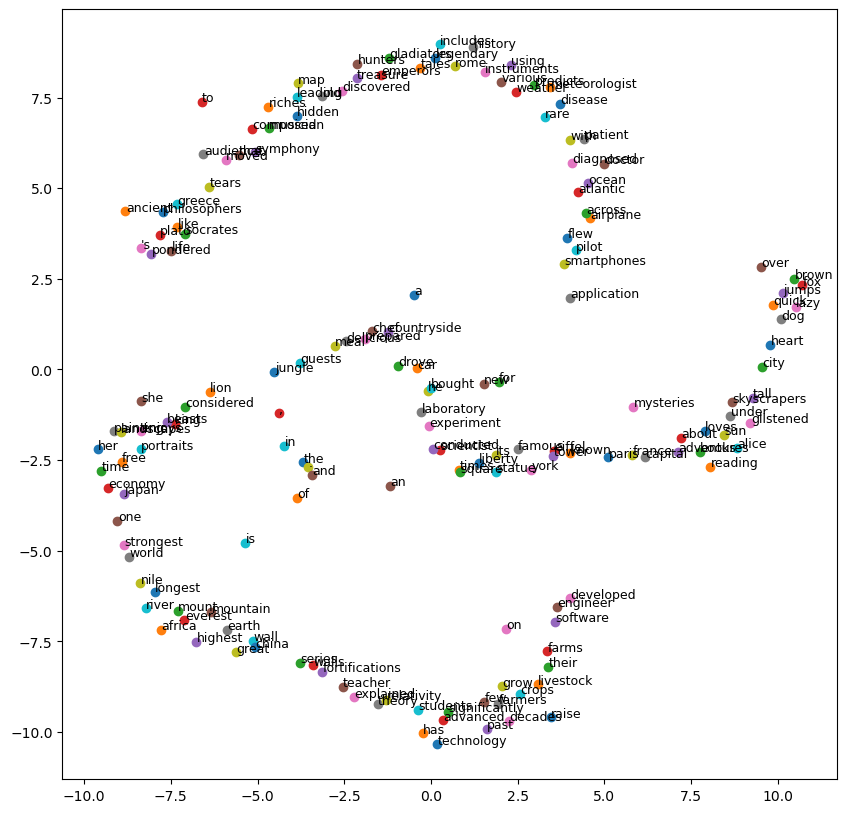

In [12]:
# Plot the embeddings
def plot_embeddings(reduced_embeddings, words):
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.text(reduced_embeddings[i, 0] + 0.01, reduced_embeddings[i, 1] + 0.01, word, fontsize=9)
    plt.show()

# Words to visualize
words_to_visualize = list(word_to_idx.keys())

# Get embeddings for the words
embeddings = get_word_embeddings(words_to_visualize, word_to_idx, model)

# Reduce dimensions using t-SNE
reduced_embeddings = reduce_dimensions(embeddings, method='tsne')

# Plot the reduced embeddings
plot_embeddings(reduced_embeddings, words_to_visualize)


### Limitations
The small custom corpus is better suited for faster training with our limited resources, however, it lacks the size for training the model to be sufficient for advanced analogical tasks.